In [1]:
from cebra import CEBRA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_hdf("data/ID18150/Day2/DataFrame_Imaging_dFF_18150_day2.h5")

In [3]:
# Get a list of columns whose names are of numerical type
numerical_columns = [col for col in df.columns if type(col) == int]

#Feature matrix
X = df[numerical_columns].values
t = df.Time.to_list()

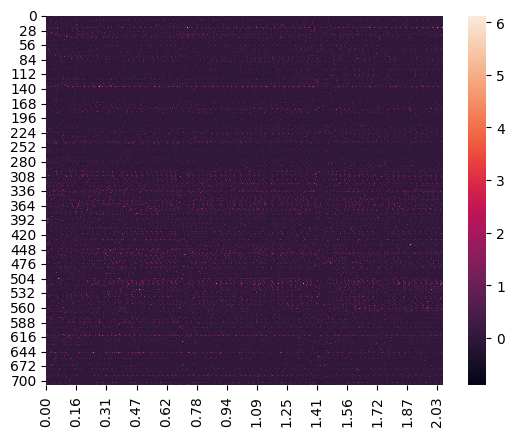

In [14]:
delta = 5000
x_ticks = np.arange(0,X.shape[0],delta)
x_tick_labels = [f"{t[i]/1000:.2f}" for i in x_ticks]
ax = sns.heatmap(X.T)
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)
plt.show()

## CEBRA Time (Naive)

In [15]:
single_cebra_time = CEBRA(
    batch_size=512,
    output_dimension=8,
    device="cuda_if_available",
    distance="cosine",
    learning_rate=3e-4,
    time_offsets=10
)
U = single_cebra_time.fit_transform(X)

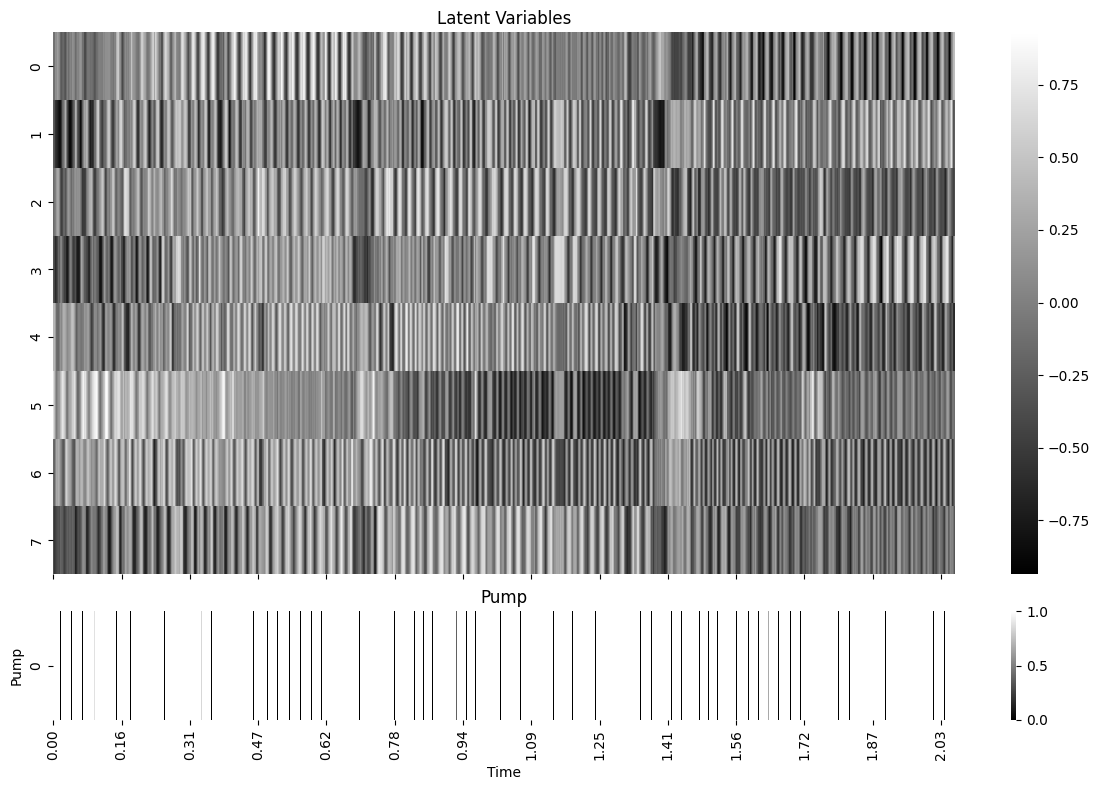

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

sns.heatmap(U.T, ax=ax1, cmap='gray')
ax1.set_title('Latent Variables')
ax1.set_xticks(x_ticks)

# Plot Pump data
sns.heatmap(1 - df['Pump'].values.reshape(1, -1), ax=ax2, cmap='gray')
ax2.set_xlabel('Time')
ax2.set_ylabel('Pump')
ax2.set_title('Pump')
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels)

plt.tight_layout()
plt.show()

## CEBRA Behavior (Pump as Continuous Label)

In [17]:
single_cebra_time = CEBRA(
    batch_size=512,
    output_dimension=8,
    device="cuda_if_available",
    distance="cosine",
    learning_rate=3e-4,
    time_offsets=10
)
U = single_cebra_time.fit_transform(X, df['Pump'].values)

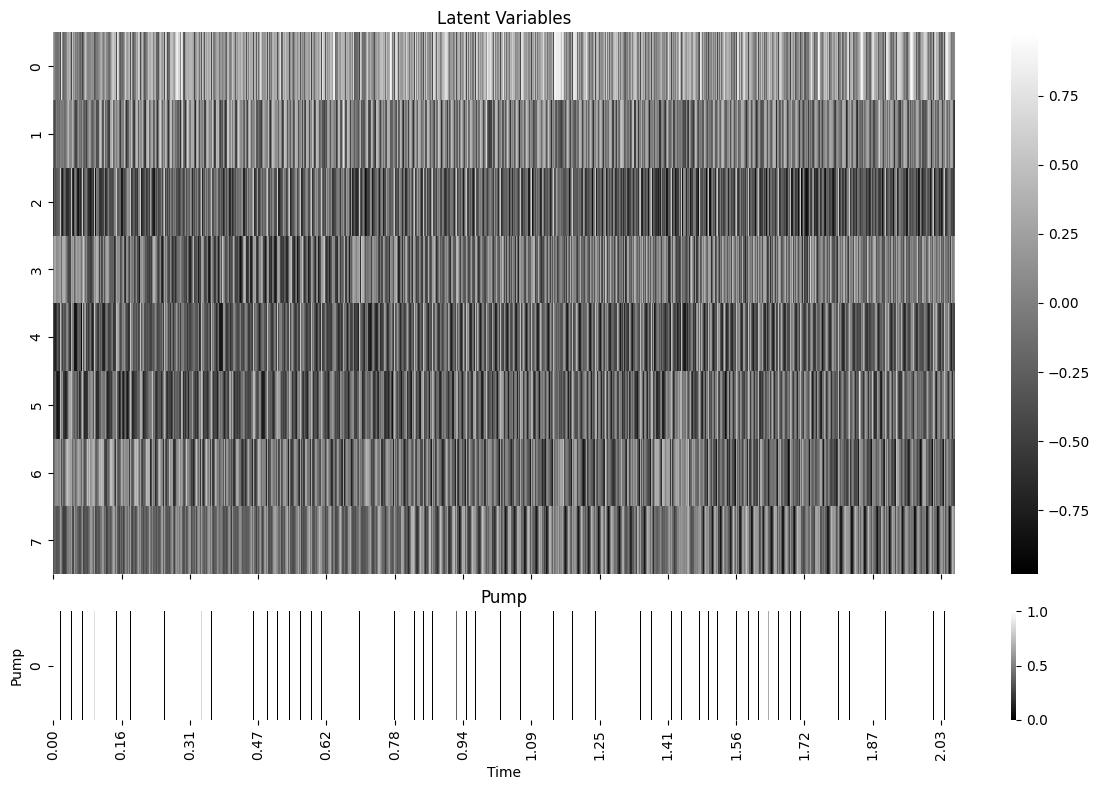

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [5, 1]})

sns.heatmap(U.T, ax=ax1, cmap='gray')
ax1.set_title('Latent Variables')
ax1.set_xticks(x_ticks)

# Plot Pump data
sns.heatmap(1 - df['Pump'].values.reshape(1, -1), ax=ax2, cmap='gray')
ax2.set_xlabel('Time')
ax2.set_ylabel('Pump')
ax2.set_title('Pump')
ax2.set_xticks(x_ticks)
ax2.set_xticklabels(x_tick_labels)

plt.tight_layout()
plt.show()